In [3]:
import pandas as pd
import plotly.express as px

In [4]:
countries_df = pd.read_csv('./data/Countries-Europe.csv')
countries_df['name'] = countries_df['name'].replace("United Kingdom", "Great Britain")
countries = countries_df["name"].values
print(countries)

['Ukraine' 'France' 'Spain' 'Sweden' 'Germany' 'Finland' 'Norway' 'Poland'
 'Italy' 'Great Britain' 'Romania' 'Belarus' 'Greece' 'Bulgaria' 'Iceland'
 'Portugal' 'Czech Republic' 'Denmark' 'Hungary' 'Serbia' 'Austria'
 'Ireland' 'Lithuania' 'Latvia' 'Croatia' 'Bosnia and Herzegovina'
 'Slovakia' 'Estonia' 'Netherlands' 'Switzerland' 'Moldova' 'Belgium'
 'Albania' 'Macedonia' 'Slovenia' 'Montenegro' 'Cyprus' 'Luxembourg'
 'Faroe Is.' 'Andorra' 'Malta' 'Liechtenstein' 'Guernsey' 'San Marino'
 'Gibraltar' 'Monaco' 'Vatican City']


In [5]:
# We need to equate country with the country code used in the data
df = pd.read_csv("./data/medallists.csv")
df["full_event"] = df["discipline"] + " " + df["event"]
df.set_index("full_event", inplace=True)
df.head()

,medal_date,medal_type,medal_code,name,gender,country,country_code,nationality,team,team_gender,discipline,event,event_type,url_event,birth_date,code
full_event,,,,,,,,,,,,,,,,
Cycling Road Men's Individual Time Trial,2024-07-27,Gold Medal,1.0,EVENEPOEL Remco,Male,Belgium,BEL,Belgium,NaN,NaN,Cycling Road,Men's Individual Time Trial,ATH,/en/paris-2024/results/cycling-road/men-s-indi...,2000-01-25,1903136.0
Cycling Road Men's Individual Time Trial,2024-07-27,Silver Medal,2.0,GANNA Filippo,Male,Italy,ITA,Italy,NaN,NaN,Cycling Road,Men's Individual Time Trial,ATH,/en/paris-2024/results/cycling-road/men-s-indi...,1996-07-25,1923520.0
Cycling Road Men's Individual Time Trial,2024-07-27,Bronze Medal,3.0,van AERT Wout,Male,Belgium,BEL,Belgium,NaN,NaN,Cycling Road,Men's Individual Time Trial,ATH,/en/paris-2024/results/cycling-road/men-s-indi...,1994-09-15,1903147.0
Cycling Road Women's Individual Time Trial,2024-07-27,Gold Medal,1.0,BROWN Grace,Female,Australia,AUS,Australia,NaN,NaN,Cycling Road,Women's Individual Time Trial,ATH,/en/paris-2024/results/cycling-road/women-s-in...,1992-07-07,1940173.0
Cycling Road Women's Individual Time Trial,2024-07-27,Silver Medal,2.0,HENDERSON Anna,Female,Great Britain,GBR,Great Britain,NaN,NaN,Cycling Road,Women's Individual Time Trial,ATH,/en/paris-2024/results/cycling-road/women-s-in...,1998-11-14,1912525.0


In [6]:
l = []
for c in countries:
    if c not in df["country"].values:
        l.append(c)

len(l) # Countries that are not in the data (this is correct because 20 european countries did not win any medals)

20

In [7]:
# We also need to determine whether to include multiple athletes from the same country who won medals in the same event
include_multiple = True
if include_multiple:
    df = df.reset_index()
    df = df.drop_duplicates(subset=["full_event", "country", "medal_code"])
    df.set_index("full_event", inplace=True)

In [8]:
# For each event, how many times did someone from our list win any medal
df['is_in'] = df["country"].isin(countries)
df["medal_wins"] = df.groupby(level=0).apply(lambda x: x["is_in"].sum())

# Let's reduce the frame to only countries that are in the list
wins_df = df[df["is_in"]]

In [9]:
# For each country, how many times did they win each medal
medal_counts = df.groupby("country")["medal_code"].value_counts().unstack().fillna(0)
medal_counts["total"] = medal_counts.sum(axis=1)
medal_counts["winpct"] = medal_counts[1] / medal_counts["total"]
medal_counts["bronzepct"] = medal_counts[3] / medal_counts["total"]
medal_counts.sort_values("winpct", ascending=True)
medal_counts["is_in"] = medal_counts.index.isin(countries)
medal_counts.head()

medal_code,1.0,2.0,3.0,total,winpct,bronzepct,is_in
country,,,,,,,
AIN,1.0,3.0,1.0,5.0,0.200000,0.200000,False
Albania,0.0,0.0,2.0,2.0,0.000000,1.000000,True
Algeria,2.0,0.0,1.0,3.0,0.666667,0.333333,False
Argentina,1.0,1.0,1.0,3.0,0.333333,0.333333,False
Armenia,0.0,3.0,1.0,4.0,0.000000,0.250000,False


In [10]:
# Let's verify that we're seeing the same mystery
insample = medal_counts[medal_counts["is_in"] == True]
golds = insample[1].sum()
silvers = insample[2].sum()
bronzes = insample[3].sum()
total = insample["total"].sum()
print(golds, silvers, bronzes, total) # <- Yup

119.0 126.0 159.0 404.0


In [11]:
# Sanity check, lets look out of sample
outsample = medal_counts[medal_counts["is_in"] == False]
golds = outsample[1].sum()
silvers = outsample[2].sum()
bronzes = outsample[3].sum()
total = outsample["total"].sum()
print(golds, silvers, bronzes, total) # <- There does seem to be some weighting towards bronze but I think we'll easally explain this later. There's still a ~5% overweighing of bronze for European countries over non-European countries

210.0 204.0 225.0 639.0


In [13]:
# Here is the result of coincidences in our countries list
events_by_medal_wins = wins_df[~wins_df.index.duplicated(keep="first")]["medal_wins"].value_counts()

print(f"Medals  Events  Total Medals  Percentage of Total Medals")
print(f"{1}         {events_by_medal_wins[1]}      {events_by_medal_wins[1]*1}         {(events_by_medal_wins[1]*1)/len(wins_df)*100:.2f}%")
print(f"{2}         {events_by_medal_wins[2]}       {events_by_medal_wins[2]*2}         {(events_by_medal_wins[2]*2)/len(wins_df)*100:.2f}%")
print(f"{3}         {events_by_medal_wins[3]}       {events_by_medal_wins[3]*3}         {(events_by_medal_wins[3]*3)/len(wins_df)*100:.2f}%")
print(f"{4}         {events_by_medal_wins[4]}        {events_by_medal_wins[4]*4}           {(events_by_medal_wins[4]*4)/len(wins_df)*100:.2f}%")

Medals  Events  Total Medals  Percentage of Total Medals
1         117      117         28.96%
2         86       172         42.57%
3         37       111         27.48%
4         1        4           0.99%


In [14]:
# So we're really only talking about the 263 events where a country from our list won a medal and didn't have to score bronze.

In [15]:
# Let's take a look at the event with 4 medals won
wins_df[wins_df["medal_wins"] == 4]

,medal_date,medal_type,medal_code,name,gender,country,country_code,nationality,team,team_gender,discipline,event,event_type,url_event,birth_date,code,is_in,medal_wins
full_event,,,,,,,,,,,,,,,,,,
Judo Women -70 kg,2024-07-31,Gold Medal,1.0,MATIC Barbara,Female,Croatia,CRO,Croatia,NaN,NaN,Judo,Women -70 kg,HATH,/en/paris-2024/results/judo/women--70-kg/fnl-0...,1994-12-03,1898499.0,True,4
Judo Women -70 kg,2024-07-31,Silver Medal,2.0,BUTKEREIT Miriam,Female,Germany,GER,Germany,NaN,NaN,Judo,Women -70 kg,HATH,/en/paris-2024/results/judo/women--70-kg/fnl-0...,1994-05-08,1563082.0,True,4
Judo Women -70 kg,2024-07-31,Bronze Medal,3.0,POLLERES Michaela,Female,Austria,AUT,Austria,NaN,NaN,Judo,Women -70 kg,HATH,/en/paris-2024/results/judo/women--70-kg/repf0...,1997-07-15,1566421.0,True,4
Judo Women -70 kg,2024-07-31,Bronze Medal,3.0,WILLEMS Gabriella,Female,Belgium,BEL,Belgium,NaN,NaN,Judo,Women -70 kg,HATH,/en/paris-2024/results/judo/women--70-kg/repf0...,1997-07-01,1903248.0,True,4


In [16]:
# Now, I would like to know when one medal is won, what % is it each rank (33% is expected all else being equal)
wins_df[wins_df["medal_wins"] == 1]["medal_type"].value_counts(normalize=True)

medal_type
Bronze Medal    0.401709
Silver Medal    0.307692
Gold Medal      0.290598
Name: proportion, dtype: float64

In [17]:
# How about when two medals are won
wins_df[wins_df["medal_wins"] == 2]["medal_type"].value_counts(normalize=True) # <- This being very close to the rate that single medals are won is interesting and also rules out the impact of some events that give bronze to all lesser place finishers as an explanation for the phenomenon

medal_type
Bronze Medal    0.406977
Silver Medal    0.308140
Gold Medal      0.284884
Name: proportion, dtype: float64

In [18]:
# Sanity check
wins_df[wins_df["medal_wins"] == 3]["medal_type"].value_counts() # equal exactly is expected (see below)

medal_type
Bronze Medal    40
Silver Medal    36
Gold Medal      35
Name: count, dtype: int64

In [19]:
# This shows that the above accounts for a tie for silver and a few ties for bronze, but the majority of the cases are as expected
wins_df[wins_df["medal_wins"] == 3].groupby(level=0)["medal_code"].sum()

full_event
3x3 Basketball Men                           6.0
Athletics Men's Triple Jump                  6.0
Athletics Women's Heptathlon                 6.0
Beach Volleyball Men                         6.0
Boxing Men's +92kg                           8.0
Canoe Slalom Men's Canoe Single              6.0
Canoe Slalom Men's Kayak Single              6.0
Canoe Sprint Women's Kayak Double 500m       8.0
Cycling BMX Racing Men                       6.0
Cycling Road Men's Individual Time Trial     6.0
Cycling Road Men's Road Race                 6.0
Cycling Track Men's Madison                  6.0
Cycling Track Men's Omnium                   6.0
Cycling Track Women's Madison                6.0
Equestrian Dressage Individual               6.0
Equestrian Dressage Team                     6.0
Equestrian Jumping Individual                6.0
Fencing Women's Sabre Individual             6.0
Fencing Women's Épée Team                    6.0
Handball Men                                 6.0
Handball 

In [20]:
# This all brings up the question, maybe Europe gets bronze ~10% more not because of their performance, but because in those events they are dominated (game theoretical) by other countries

In [21]:
lost_to = []
won_to = []

for event in df[df["medal_wins"] == 1].index.unique():
    event_df = df.loc[event]
    # Get the placement (medal_code) of our country
    placement = event_df[event_df["country"].isin(countries)]["medal_code"].values[0]
    if placement == 3: # Bronze
        # Get the other countries that won medals
        other_countries = event_df[~event_df["country"].isin(countries)]["country"].values
        lost_to.extend(other_countries)
    elif placement == 1: # Gold
        # Get the other countries that won medals
        other_countries = event_df[~event_df["country"].isin(countries)]["country"].values
        won_to.extend(other_countries)
    elif placement == 2:
        # Get the counties with medal_code 1
        other_countries = event_df[event_df["medal_code"] == 1]["country"].values
        lost_to.extend(other_countries)
        # Get the counties with medal_code 3
        other_countries = event_df[event_df["medal_code"] == 3]["country"].values
        won_to.extend(other_countries)
    else:
        print("Error")

In [22]:
# count occurrences of each country
lost = pd.Series(lost_to).value_counts()
won = pd.Series(won_to).value_counts()

# merge the two series on the index
dominance_matrix = pd.DataFrame({"lost_to": lost, "won_to": won})

# calculate the percentage difference
dominance_matrix["total"] = dominance_matrix.sum(axis=1)
dominance_matrix['diff'] = (dominance_matrix["won_to"] - dominance_matrix["lost_to"])
dominance_matrix["winpct"] = dominance_matrix["won_to"] / dominance_matrix["total"]
dominance_matrix[dominance_matrix['total'] > 4].sort_values("winpct", ascending=True)

,lost_to,won_to,total,diff,winpct
Uzbekistan,6.0,2.0,8.0,-4.0,0.250000
Korea,11.0,5.0,16.0,-6.0,0.312500
China,21.0,10.0,31.0,-11.0,0.322581
United States,26.0,18.0,44.0,-8.0,0.409091
Brazil,7.0,6.0,13.0,-1.0,0.461538
Japan,8.0,8.0,16.0,0.0,0.500000
Canada,5.0,6.0,11.0,1.0,0.545455
Australia,9.0,11.0,20.0,2.0,0.550000
Kenya,3.0,4.0,7.0,1.0,0.571429
New Zealand,3.0,4.0,7.0,1.0,0.571429


In [23]:
dominance_matrix[dominance_matrix["diff"].abs() > 2]["diff"].sum()

-29.0

In [24]:
# Out of the 263 events in question we expect to lose 29 to a team who generally perform better across events, which is actually more impact than the 5% we were looking for.
# This wouldn't explain why this seems to happen to Europe but not nessisarally any individual country. So we should check this assumption...
# Do any individual countries (both insample and out) have a similar distribution of medals?

<Axes: xlabel='total'>

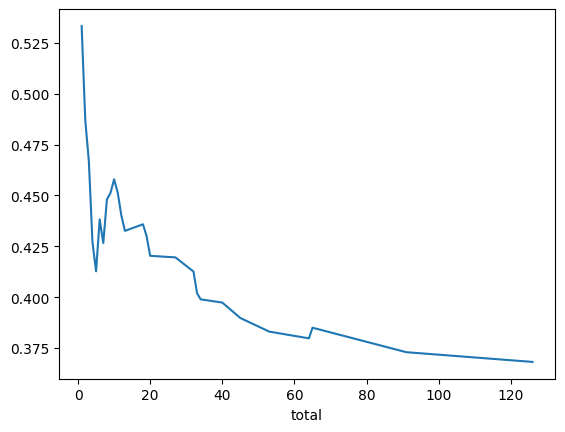

In [25]:
# What's the distribution of bronze medals won by countries based on the total number of medals they've won
total = pd.DataFrame(
    {
        "total": medal_counts.groupby("total")["total"].sum(),
        "bronze": medal_counts.groupby("total")[3].sum(),
    }
)
dist = total["bronze"].cumsum() / total["total"].cumsum()
dist.plot()

In [26]:
# For example, what is the average percentage of bronze medals won by countries that won more than n(10) medals
medal_counts[medal_counts["total"] > 10]["bronzepct"].mean()

0.3337593357963451

In [27]:
# Less than n medals
medal_counts[medal_counts["total"] < 10]["bronzepct"].mean()

0.45827097505668934

In [28]:
# Let's graph bronze as a function of total medals
fig = px.scatter(
    medal_counts,
    x="bronzepct",
    y="total",
    text=medal_counts.index,
    title="Win Percentage vs Total Medals",
    color=medal_counts["is_in"],  # Add color based on the "is_in" column
    color_discrete_map={True: "red", False: "green"},  # Define color mapping
)
fig.update_traces(textposition='top center')
# plot 33% line
fig.add_shape(
    type="line",
    x0=0.3333,
    x1=0.3333,
    y0=0,
    y1=140,
    line=dict(color="blue", width=1),
)
fig.show()

In [29]:
# Let's look at each countries contribution to the bronze medals won by the set
insample = medal_counts[medal_counts["is_in"]].copy()
t = insample[3].sum()
insample["bronzeContrib"] = medal_counts[3] / t
top = insample[(insample[3] > 3) & (insample["bronzepct"] > 0.33) & (insample["bronzeContrib"] > 0.05)]
print(top['bronzeContrib'].sum())
top

0.5471698113207547


medal_code,1.0,2.0,3.0,total,winpct,bronzepct,is_in,bronzeContrib
country,,,,,,,,
France,16.0,26.0,22.0,64.0,0.250000,0.343750,True,0.138365
Great Britain,14.0,22.0,29.0,65.0,0.215385,0.446154,True,0.182390
Italy,12.0,13.0,15.0,40.0,0.300000,0.375000,True,0.094340
Netherlands,15.0,7.0,12.0,34.0,0.441176,0.352941,True,0.075472
Spain,5.0,4.0,9.0,18.0,0.277778,0.500000,True,0.056604


Two phenomena are occuring simultaneously.

The first, is that the majority of countries are winning more bronze medals than anything else.
Countries that win more medals tend to meanrevert to 33% bronze with countries that win less in total (but still some), favoring a 3rd place finish.
I show that this is expalined by event dominance (and we can infer that this, itself, is likely expalained through a function of funding and population differences).

However, this is not what's effecting our sample of European countries.<br>
More than half of the bonze medals won by the countries in our sample are won by countries that are winning lots of medals AND still disspropotionally bronze.

The second phenomenon we see is that, countries that are winning the most medals for Europe (and thus are effecting the total counts the most) are mostly (more than the normalized 33%) winning bronze.
This is because they in events where they perform well enough to podium, they are generally performing worse than a few other countries that are not in our sample (namely China and to a lesser extent the US, Korea, and Uzbekistan).
This condition sufficiently explains the distribution of Bronze finishes for the population of European countries both individually and in aggregate.

In [31]:
# What would happen if we removed these countries from the sample?
wins_df[
    (wins_df["medal_wins"] == 1)
    & (wins_df["country"] != "Great Britain")
    & (wins_df["country"] != "France")
    & (wins_df["country"] != "Italy")
    & (wins_df["country"] != "Netherlands")
    & (wins_df["country"] != "Spain")
]["medal_type"].value_counts(normalize=True) # <- the medal distribution is now as expected

medal_type
Silver Medal    0.347826
Gold Medal      0.326087
Bronze Medal    0.326087
Name: proportion, dtype: float64